In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [79]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    return out

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [20]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [21]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

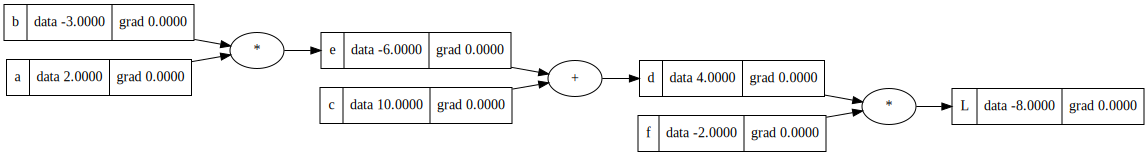

In [22]:
draw_dot(L)

Eg1: Manual Backpropogation

In [ ]:
#d_ - derivative

# L = d * f

# dL/dL = 1.0

# dL/dd = f
# dL/df = d

#chain of rule
# d = e + c
# dd/de = 1
# dd/dc = 1

# dL/de = dL/dd  * dd/de = f * 1 = f
# dL/dc = dL/dd  * dd/dc = f * 1 = f

# e = a*b
# de/da = b
# de/db = a

# dL/da = dL/de * de/da = dL/dd * dd/de * de/da = f * 1 * b
# dL/db = dL/de * de/db = dL/dd * dd/de * de/db = f * 1 * a

In [57]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = f.data
e.grad = f.data
a.grad = f.data * b.data
b.grad = f.data * a.data

In [59]:
# inline gradient calculation with small step size

def test():
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L1 = d * f; L.label = 'L'
  L1

  h = 0.0001

  a = Value(2.0, label='a')
  #a gradient calculation
  #a.data += h

  b = Value(-3.0, label='b')
  #b gradient calculation
  # b.data += h

  c = Value(10.0, label='c')
  #c gradient calculation
  #c.data += h

  e = a*b; e.label = 'e'
  #e gradient calculation
  #e.data += h

  d = e + c; d.label = 'd'

  #d gradient calculation
  # d.data += h

  f = Value(-2.0, label='f')

  #f gradient calculation
  # f.data += h

  L2 = d * f; L.label = 'L'

  #L gradient calculation
  # L2.data += h

  print((L2.data - L1.data)/h) #slope

test()

-4.000000000008441


In [60]:
#L - Loss function  - Need to minimize it
#Back Propogation: Apply the calculated gradient w.r.t loss function to the inputs
#which reduces the loss function

#0.01 is a step size

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data) #reduced from -8 to -7.2

-7.286496


Eg:2 Manual Back Propogation

In [59]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

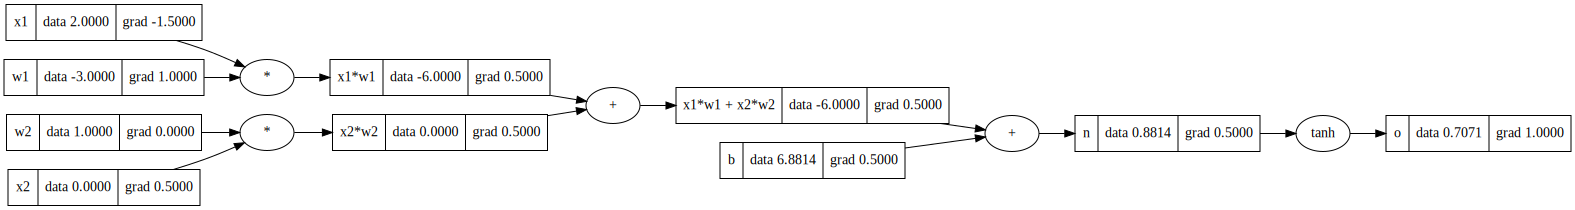

In [62]:
draw_dot(o)

In [ ]:
#o = tanh(n)
#do/dn = 1 - o ** 2

In [75]:
o.grad = 1.0

n.grad = (1 - o.data ** 2) * o.grad

b.grad = n.grad
x1w1x2w2.grad = n.grad

x1w1.grad = x1w1x2w2.grad #= do/dx1w1
x2w2.grad = x1w1x2w2.grad

x1.grad = x1w1.grad * w1.data # = do/dx1 = do/dx1w1 * dx1w1/dx1
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

Back Propogation via Code

In [61]:
o.backward()

Implementing with Pytorch

In [63]:
import torch

In [64]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Creating our own neuron

In [56]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin, nout):
    sz = [nin] + nout
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0] #number of weights in neuron is proportional to input
n = MLP(3, [4,4,1]) # 3 inputs, two hidden layers (4 neurons each), 1 output
n(x) 

Value(data=0.7384869657073204)

In [52]:
n.parameters()

[Value(data=-0.012358809075424082),
 Value(data=-0.428576330433158),
 Value(data=-0.4018810907264634),
 Value(data=0.710176276818115),
 Value(data=-0.5710304083953759),
 Value(data=-0.008737997305227507),
 Value(data=0.36950570054780085),
 Value(data=-0.3133022161419141),
 Value(data=-0.6115840054141475),
 Value(data=-0.38886501057351164),
 Value(data=0.1542355340333934),
 Value(data=0.9432609546438777),
 Value(data=0.8250945386403727),
 Value(data=-0.9067107735313924),
 Value(data=0.43600672237973237),
 Value(data=0.7334339433028803),
 Value(data=-0.8973945962461585),
 Value(data=-0.6363208964767322),
 Value(data=0.47642002936912586),
 Value(data=-0.6547828774146156),
 Value(data=-0.7612488022698682),
 Value(data=0.5476602699038133),
 Value(data=0.16252004063520453),
 Value(data=0.7846893498761136),
 Value(data=0.06549139318508845),
 Value(data=0.5912437612189141),
 Value(data=0.01773507556565357),
 Value(data=-0.43826820509103426),
 Value(data=-0.12002163504112096),
 Value(data=0.355

Training

In [75]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [66]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7384869657073204),
 Value(data=0.9214583768835521),
 Value(data=0.7462080034390614),
 Value(data=0.8784701675424718)]

In [80]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.005544113654616432
1 0.005544113654616432
2 0.005544113654616432
3 0.005544113654616432
4 0.005544113654616432
5 0.005544113654616432
6 0.005544113654616432
7 0.005544113654616432
8 0.005544113654616432
9 0.005544113654616432
10 0.005544113654616432
11 0.005544113654616432
12 0.005544113654616432
13 0.005544113654616432
14 0.005544113654616432
15 0.005544113654616432
16 0.005544113654616432
17 0.005544113654616432
18 0.005544113654616432
19 0.005544113654616432
